# Minplus algebra experiment

This code attempts to learn the 2D mixture prior
$J(x) = min(\frac{1}{2t\sigma_{1}}||x-\mu_{1}||^{2}, \frac{1}{2\sigma_{2}}||x-\mu_{2}||^{2})$
assuming we have access to training data $\{y_i, S(y_i)\} = min_{x \in \R} \ \{0.5||x-y_i||^{2}_{2} + J(x)\}\}$.

This is ostensibly the same code as the file in the _hjpdes_experiments_1D folder, except that we use here
the LPN module directly. This is because the experiments in _hjpdes_experiments_1D rely on the utils.py and network.py
files which assume the input is one-dimensional.

## Import modules 

In [1]:
import os
import numpy as np
import torch

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns

from network import LPN
from lib.utils import cvx
from lib.invert import invert


# set location
MODEL_DIR = "experiments/models/minplus_2D"
os.makedirs(MODEL_DIR, exist_ok=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set random seeds
np.random.seed(1)
torch.manual_seed(1)

# plotting options
plt.rcParams.update({"text.usetex": True})
sns.set_theme()

Notes: The Euclidean norm function requires something for the tensor gradient... fix this later...

## Parameters, utility functions, and plotting tool

In [2]:
#--- Parameters ---#
# dimension
dim = 2

# prior parameters
mu1 = np.array([1.0, 0.0])
mu2 = np.array([1.0, 1.0]/np.sqrt(2.0))
sigma1 = 1.0
sigma2 = 1.0

# LPN model parameters
beta = 10       # beta of softplus
hidden = 100     # number of hidden units
layers = 6      # number of layers

# Defaults: beta = 10, hidden = 50, layers = 4

# optimization algorithm to use for computing the prior
# cvx_cg, cvx_gd
INVERT_MODE = "cvx_gd"


#--- Utility functions ---#
def euclid_norm(x):
    return np.linalg.norm(x, ord = 2, axis = 1)

def inner_prod(x,y):
    return np.sum(x*y, axis = 1)

# Proximal matching loss (-exp(-(x/gamma)^2) + 1) for training the LPN
def exp_func(x, gamma):
    return -torch.exp(-((torch.linalg.vector_norm(x, ord = 2, dim = 1)/ gamma) ** 2)) + 1.0

# Target convex function to train
def cvx_true(y,mu1,mu2,sigma1,sigma2):
    val1 = 0.5*pow(euclid_norm(y-mu1),2)/(1+sigma1)
    val2 = 0.5*pow(euclid_norm(y-mu2),2)/(1+sigma2)
    val = 0.5*pow(euclid_norm(y),2) - np.minimum(val1,val2)
    return val

# Target prior function to learn
def prior_true(y,mu1,mu2,sigma1,sigma2):
    val1 = 0.5*pow(euclid_norm(y-mu1),2)/sigma1
    val2 = 0.5*pow(euclid_norm(y-mu2),2)/sigma2
    val = np.minimum(val1,val2)
    return val


#--- Plotting tool ---#
# 1) This plot the estimated convex and prior functions
# There seems to be an issue with evaluating the prior?
def plot_all(model,a,b,data_points,mu1,mu2,sigma1,sigma2):

    # Create a meshgrid over [a,b]^2 with data_points*3 points
    spacing = data_points*3
    xi = np.linspace(a, b, spacing)

    # Compute points along the cross-sections (x1,0) and (0,x2).
    x1_0_points = np.array(np.meshgrid(xi, 0)).reshape(2, -1).T
    x2_0_points = np.array(np.meshgrid(0, xi)).reshape(2, -1).T

    # Compute the true convex and prior functions at these cross-sections
    x1_0_cvx_true = cvx_true(x1_0_points,mu1,mu2,sigma1,sigma2)
    x2_0_cvx_true = cvx_true(x2_0_points,mu1,mu2,sigma1,sigma2)

    x1_0_prior_true = prior_true(x1_0_points,mu1,mu2,sigma1,sigma2)
    x2_0_prior_true = prior_true(x2_0_points,mu1,mu2,sigma1,sigma2)

    # Compute the estimated convex and prior functions at these cross-sections
    x1_0_cvx_est = cvx(x1_0_points,model)
    x2_0_cvx_est = cvx(x2_0_points,model)

    # Evaluate the prior
    y = invert(x1_0_points,model,INVERT_MODE)
    y_torch = torch.tensor(y).float().to(device)
    psi = model.scalar(y_torch).squeeze(1).detach().cpu().numpy()
    x1_0_prior_est =  np.sum(x1_0_points*y, axis = 1) - 0.5 * euclid_norm(x1_0_points) - psi

    y = invert(x2_0_points,model,INVERT_MODE)
    y_torch = torch.tensor(y).float().to(device)
    psi = model.scalar(y_torch).squeeze(1).detach().cpu().numpy()
    x2_0_prior_est =  np.sum(x2_0_points*y, axis = 1) - 0.5 * euclid_norm(x2_0_points) - psi

    # DEBUG: Prior is not working too well. Could it because of the way we compute the convex function?


    # Plot cross section (x1,0) of the convex function
    plt.subplots()
    plt.plot(xi, x1_0_cvx_est, "-", ms=5,label="LPN")
    plt.plot(xi, x1_0_cvx_true, "-", ms=5,label="Ref")
    plt.grid("on")
    plt.title("Cross sections ($x_1$,0) of the convex function")
    plt.xlabel('$x_1$')
    plt.ylabel('Convex functions ($x_1$,0)')
    plt.legend()


    # Plot cross section (0,x2) of the convex function
    plt.subplots()
    plt.plot(xi, x2_0_cvx_est, "-", ms=5,label="LPN")
    plt.plot(xi, x2_0_cvx_true, "-", ms=5,label="Ref")
    plt.grid("on")
    plt.title("Cross sections (0,$x_2$) of the convex function")
    plt.xlabel('$x_2$')
    plt.ylabel('Convex functions (0, $x_2$)')
    plt.legend()


    # Plot cross section (x1,0) of the prior function
    plt.subplots()
    plt.plot(xi, x1_0_prior_est, "-", label="LPN")
    plt.plot(xi, x1_0_prior_true, "-", label="Ref")
    plt.grid("on")
    plt.title("Cross sections ($x_1$,0) of the prior function")
    plt.xlabel('$x_1$')
    plt.ylabel('Prior functions ($x_1$,0)')
    plt.legend()


    # Plot cross section (0,x2) of the prior function
    plt.subplots()
    plt.plot(xi, x2_0_prior_est, "-", label="LPN")
    plt.plot(xi, x2_0_prior_true, "-", label="Ref")
    plt.grid("on")
    plt.title("Cross sections (0,$x_2$) of the prior function")
    plt.xlabel('$x_2$')
    plt.ylabel('Prior functions (0, $x_2$)')
    plt.legend()

 
    # # 3D plot of the convex function
    # plt.subplot(1, 2, 1)
    # plt.plot(xi, c, "-", ms=5, label="Cvx func")
    # plt.plot(xi, cvx_true(xi,mu1,mu2,sigma1,sigma2), "--", label="ref.", zorder=1.9)
    # plt.grid("on")
    # plt.legend()
    # plt.title("Cvx func")

    # # 3D plot of the original function
    # plt.subplot(1, 2, 2)
    # plt.plot(xi, p, label="LPN")
    # plt.plot(xi, prior_true(xi,mu1,mu2,sigma1,sigma2), "--", label="ref", zorder=1.9)
    # plt.grid("on")
    # plt.legend()
    # plt.title("Original func")

    # plt.tight_layout()




# Old
# True proximal operator we want to reconstruct
# def prox_true(y,mu1,mu2,sigma1,sigma2):
#     val1 = 0.5*pow(euclid_norm(y-mu1),2)/(1+sigma1)
#     val2 = 0.5*pow(euclid_norm(y-mu2),2)/(1+sigma2)
#     val = (mu1 + sigma1*y)*(val1 <= val2)/(1 + sigma1) + (mu2 + sigma2*y)*(val1 > val2)/(1+sigma2)
#     return val

#y = prox(xi, model)
# # learned prox
# plt.subplot(1, 3, 1)
# plt.plot(xi, y, "-", ms=5, label="LPN")
# plt.plot(xi, prox_true(xi,mu1,mu2,sigma1,sigma2), "--", label="ref.", zorder=1.9)
# plt.grid("on")
# plt.legend()
# plt.title("Learned prox")


# Example: Visualize the target convex and prior functions

Text(0, 0.5, 'prior_true($x_2$,0)')

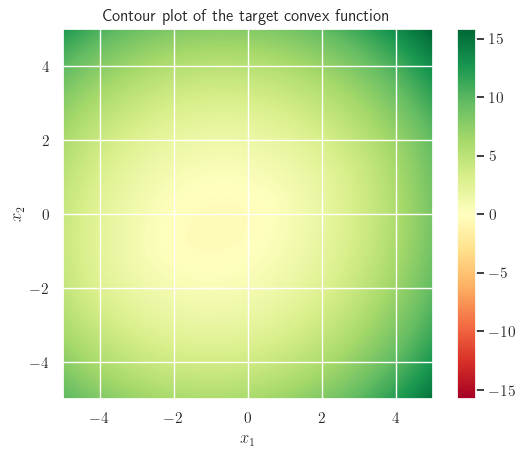

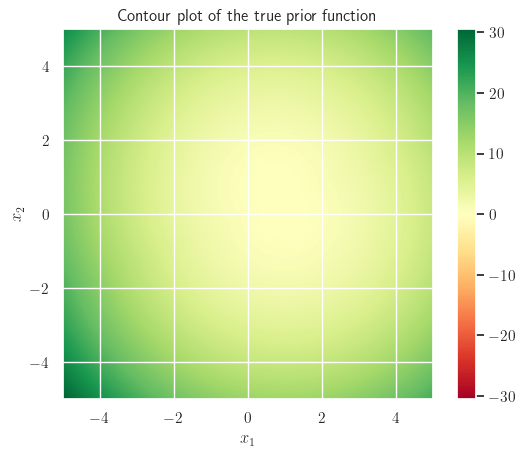

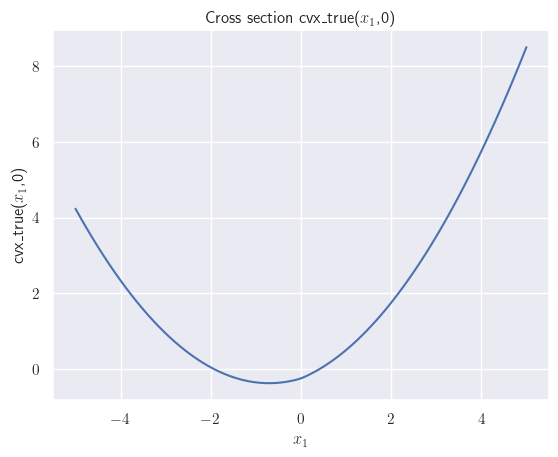

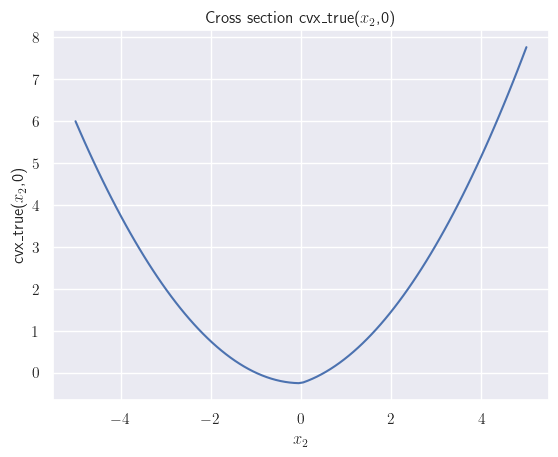

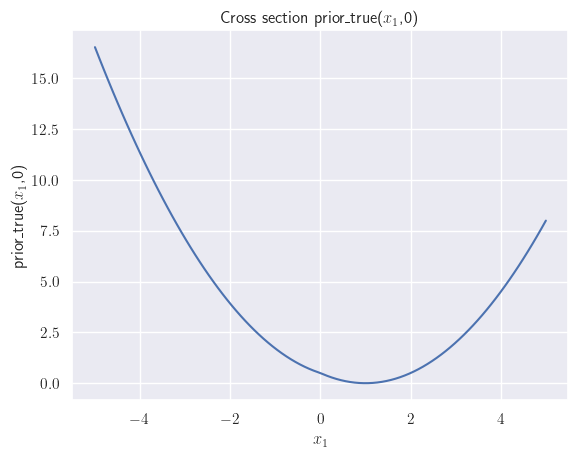

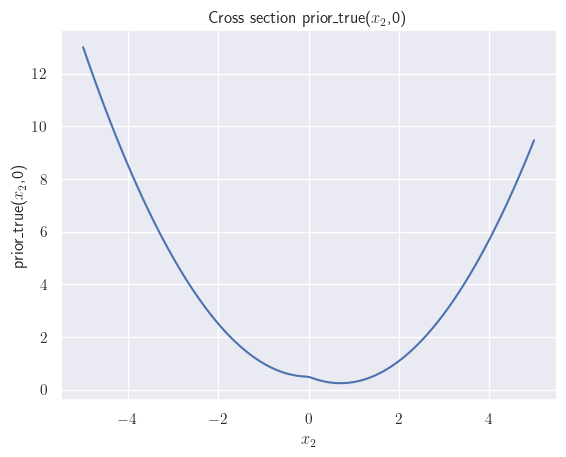

In [3]:
# Generate an [-a, a]^2 square meshgrid
a, spacing = 5, 100
xi = np.linspace(-a, a, spacing)
mesh = np.meshgrid(xi, xi) 

# Recover the list of points as a matrix with 2 columns
pts = np.array(mesh).reshape(2, -1).T

# Evaluate the target convex and prior functions, then reshape them to fit the meshgrid
example_cvx_true = cvx_true(pts,mu1,mu2,sigma1,sigma2).reshape(spacing,-1)
example_prior_true = prior_true(pts,mu1,mu2,sigma1,sigma2).reshape(spacing,-1)

# Plot 2D contours cvx_true(x1,x2) = C
fig1, ax1 = plt.subplots()
im1 = ax1.imshow(example_cvx_true, interpolation='bilinear', cmap=cm.RdYlGn,
               origin='lower', extent=[-a, a, -a, a],
               vmax=abs(example_cvx_true).max(), vmin=-abs(example_cvx_true).max())

plt.title('Contour plot of the target convex function')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.colorbar(im1)

# Plot 2D contours prior_true(x1,x2) = C
fig2, ax2 = plt.subplots()
im2 = ax2.imshow(example_prior_true, interpolation='bilinear', cmap=cm.RdYlGn,
               origin='lower', extent=[-a, a, -a, a],
               vmax=abs(example_prior_true).max(), vmin=-abs(example_prior_true).max())

plt.title('Contour plot of the true prior function')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.colorbar(im2)

# Plot the cross sections cvx_true(x1,0), cvx_true(0,x2), prior_true(x1,0) and prior_true(0,x2)
x1_0_points = np.array(np.meshgrid(xi, 0) ).reshape(2, -1).T
x2_0_points = np.array(np.meshgrid(0, xi) ).reshape(2, -1).T

x1_0_cvx_true = cvx_true(x1_0_points,mu1,mu2,sigma1,sigma2).reshape(spacing,-1)
x2_0_cvx_true = cvx_true(x2_0_points,mu1,mu2,sigma1,sigma2).reshape(spacing,-1)

x1_0_prior_true = prior_true(x1_0_points,mu1,mu2,sigma1,sigma2).reshape(spacing,-1)
x2_0_prior_true = prior_true(x2_0_points,mu1,mu2,sigma1,sigma2).reshape(spacing,-1)

plt.subplots()
plt.plot(xi, x1_0_cvx_true, "-", ms=5)
plt.grid("on")
plt.title("Cross section cvx_true($x_1$,0)")
plt.xlabel('$x_1$')
plt.ylabel('cvx_true($x_1$,0)')

plt.subplots()
plt.plot(xi, x2_0_cvx_true, "-", ms=5)
plt.grid("on")
plt.title("Cross section cvx_true($x_2$,0)")
plt.xlabel('$x_2$')
plt.ylabel('cvx_true($x_2$,0)')

plt.subplots()
plt.plot(xi, x1_0_prior_true, "-", ms=5)
plt.grid("on")
plt.title("Cross section prior_true($x_1$,0)")
plt.xlabel('$x_1$')
plt.ylabel('prior_true($x_1$,0)')

plt.subplots()
plt.plot(xi, x2_0_prior_true, "-", ms=5)
plt.grid("on")
plt.title("Cross section prior_true($x_2$,0)")
plt.xlabel('$x_2$')
plt.ylabel('prior_true($x_2$,0)')

## Generate training data

In [4]:
# generate samples {yi} uniformly in the square [a,b]
data_points = 200
a = -4
b = 4

input = np.zeros((2,data_points))
input[0] = np.random.uniform(a,b,data_points)
input[1] = np.random.uniform(a,b,data_points)
input = input.reshape(data_points,2)

# Generate the samples
cvx_samples = cvx_true(input,mu1,mu2,sigma1,sigma2).reshape(data_points,-1)

# Recast and samples as tensors
input = torch.from_numpy(input).float()
cvx_samples = torch.from_numpy(cvx_samples).float()

## Training function

In [5]:
def single_iteration(i, data_points, lpn_model, optimizer, loss_type, gamma_loss=None):
    # Compute the convex function from the input
    cvx_out = lpn_model.scalar(input)

    # Calculate the loss function
    if loss_type == 2:
        loss = (cvx_out - cvx_samples).pow(2).sum() / data_points   # MSE loss
    elif loss_type == 1:
        loss = (cvx_out - cvx_samples).abs().sum() / data_points    # MAE loss
    elif loss_type == 0:
        loss = exp_func(cvx_out - cvx_samples, gamma_loss).mean()   # proximal matching loss
    else:
        raise ValueError("loss_type must be 0, 1, or 2")


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lpn_model.wclip()

    # monitor
    # loss_lstar = exp_func(out - target, 0.1).mean()

    if not i % 500:
        print("iteration", i, "loss", loss.item()) #, "loss_lstar", loss_lstar.item())

# Train

L2 loss -- Train

In [6]:
# initialize
lpn_model = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta).to(device)
optimizer = torch.optim.Adam(lpn_model.parameters(), lr=1e-3)

for i in range(1):
    single_iteration(i, data_points, lpn_model, optimizer, loss_type=2)

for g in optimizer.param_groups:
    g["lr"] = 1e-4
for i in range(40000):
    single_iteration(i, data_points, lpn_model, optimizer, loss_type=2)


# save the model
torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, "l2.pth"))

iteration 0 loss 14.092735290527344
iteration 0 loss 152566.3125
iteration 500 loss 2000.0562744140625
iteration 1000 loss 550.6840209960938
iteration 1500 loss 231.87254333496094
iteration 2000 loss 115.3661880493164
iteration 2500 loss 62.266666412353516
iteration 3000 loss 34.98984909057617
iteration 3500 loss 20.054414749145508
iteration 4000 loss 11.52108383178711
iteration 4500 loss 6.524561882019043
iteration 5000 loss 3.612943172454834
iteration 5500 loss 1.9370315074920654
iteration 6000 loss 1.0106557607650757
iteration 6500 loss 0.5313665270805359
iteration 7000 loss 0.3061913549900055
iteration 7500 loss 0.2131935954093933
iteration 8000 loss 0.18009592592716217
iteration 8500 loss 0.16862744092941284
iteration 9000 loss 0.16220912337303162
iteration 9500 loss 0.15557587146759033
iteration 10000 loss 0.14763829112052917
iteration 10500 loss 0.13823583722114563
iteration 11000 loss 0.12739859521389008
iteration 11500 loss 0.11528056114912033
iteration 12000 loss 0.1023177430

L2 loss -- Plot

loss -127.09423828125
loss -696.8021850585938
loss -1156.33984375
loss -1540.197509765625
loss -1876.6207275390625
loss -2159.6328125
loss -2391.61328125
loss -2582.86328125
loss -2747.31787109375
loss -2885.12939453125
loss -3001.62841796875
loss -3099.8642578125
loss -3182.45068359375
loss -3253.76318359375
loss -3316.39794921875
loss -3375.2734375
loss -3433.486328125
loss -3492.115478515625
loss -3551.394287109375
loss -3611.22265625
loss -3671.400390625
loss -3731.712890625
loss -3791.961181640625
loss -3851.97607421875
loss -3911.6474609375
loss -3970.949462890625
loss -4029.929443359375
loss -4088.664306640625
loss -4147.22119140625
loss -4205.64453125
loss -4263.96435546875
loss -4322.1982421875
loss -4380.35400390625
loss -4438.4423828125
loss -4496.47119140625
loss -4554.4365234375
loss -4612.3603515625
loss -4670.2451171875
loss -4728.0908203125
loss -4785.8994140625
final mse:  0.09394539147615433
max, min: 18.342962 -19.018055
loss -127.09423828125
loss -735.1845703125
los

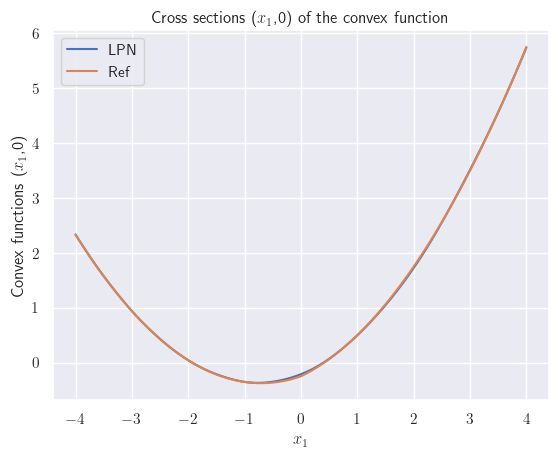

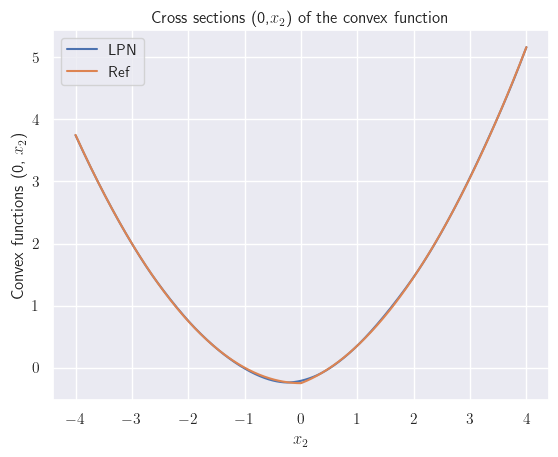

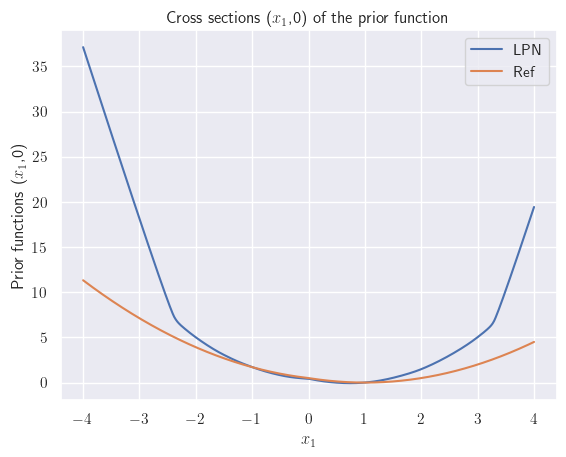

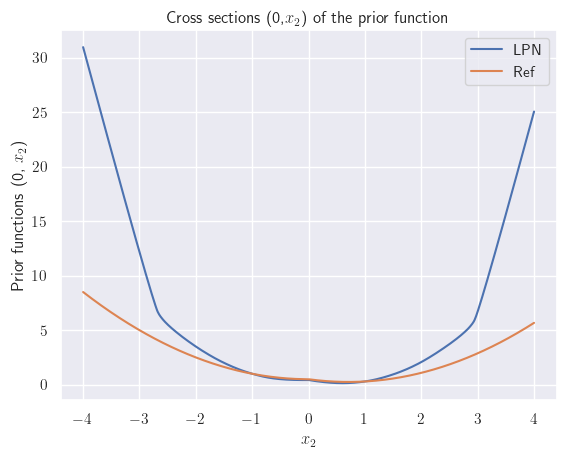

In [7]:
plot_all(lpn_model,a,b,data_points,mu1,mu2,sigma1,sigma2)

L1 loss -- Train

In [8]:
# initialize
lpn_model = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta).to(device)
optimizer = torch.optim.Adam(lpn_model.parameters(), lr=1e-3)

loss_type = 1

for i in range(1):
    single_iteration(i, data_points, lpn_model, optimizer, loss_type)

for g in optimizer.param_groups:
    g["lr"] = 1e-4
for i in range(20000):
    single_iteration(i, data_points, lpn_model, optimizer, loss_type)


# save the model
torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, "l1.pth"))

iteration 0 loss 2.822303533554077
iteration 0 loss 417.368896484375
iteration 500 loss 11.179758071899414
iteration 1000 loss 1.8223671913146973
iteration 1500 loss 0.4473256766796112
iteration 2000 loss 0.3632497489452362
iteration 2500 loss 0.29638051986694336
iteration 3000 loss 0.21897880733013153
iteration 3500 loss 0.15600235760211945
iteration 4000 loss 0.10932333022356033
iteration 4500 loss 0.07269705086946487
iteration 5000 loss 0.045670200139284134
iteration 5500 loss 0.023661326617002487
iteration 6000 loss 0.015543032437562943
iteration 6500 loss 0.014161752536892891
iteration 7000 loss 0.011958032846450806
iteration 7500 loss 0.015653375536203384
iteration 8000 loss 0.018495911732316017
iteration 8500 loss 0.01322699710726738
iteration 9000 loss 0.012283355928957462
iteration 9500 loss 0.01230178028345108
iteration 10000 loss 0.013158641755580902
iteration 10500 loss 0.011738005094230175
iteration 11000 loss 0.012613510712981224
iteration 11500 loss 0.01292560063302517
i

L1 loss -- Plot

loss -113.22364044189453
loss -681.3109130859375
loss -1153.7049560546875
loss -1546.276611328125
loss -1875.2598876953125
loss -2151.418701171875
loss -2382.701904296875
loss -2578.036376953125
loss -2743.53857421875
loss -2882.947265625
loss -3000.651123046875
loss -3105.744384765625
loss -3204.014892578125
loss -3298.54345703125
loss -3390.94287109375
loss -3481.992919921875
loss -3572.31689453125
loss -3662.40771484375
loss -3752.518798828125
loss -3842.640625
loss -3932.669921875
loss -4022.530029296875
loss -4112.1875
loss -4201.625
loss -4290.8251953125
loss -4379.7744140625
loss -4468.462890625
loss -4556.896484375
loss -4645.0859375
loss -4733.0556640625
loss -4820.8330078125
loss -4908.44189453125
loss -4995.9140625
loss -5083.265625
loss -5170.51171875
loss -5257.66357421875
loss -5344.7314453125
loss -5431.73876953125
loss -5518.6865234375
loss -5605.5712890625
final mse:  0.161598339676857
max, min: 18.813332 -19.174248
loss -113.22364044189453
loss -719.2534790039062
loss

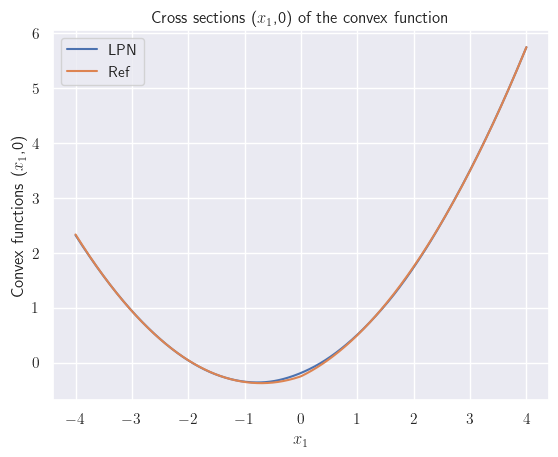

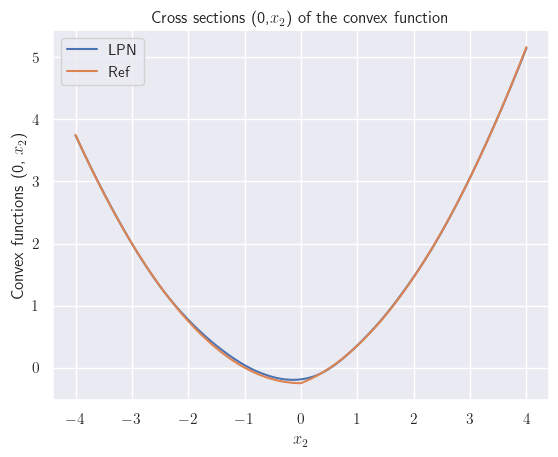

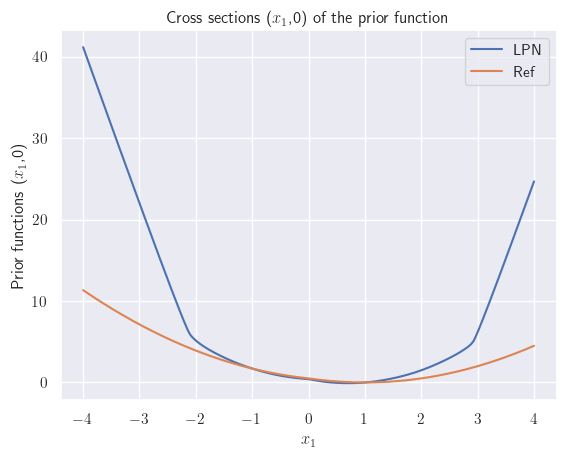

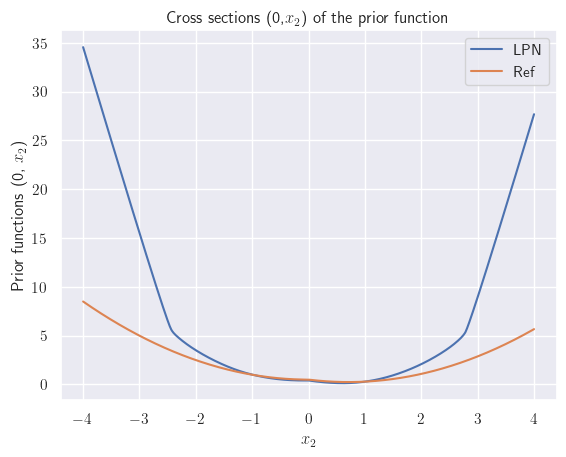

In [9]:
plot_all(lpn_model,a,b,data_points,mu1,mu2,sigma1,sigma2)

Proximal matching loss.
We perform proximal matching loss with a decreasing sequence of gamma parameters.

gamma = 20 -- Train

In [17]:
lpn_model = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta).to(device)
optimizer = torch.optim.Adam(lpn_model.parameters(), lr=1e-3)

loss_type = 0
gamma_loss = 20

# set learning rate
for g in optimizer.param_groups:
    g["lr"] = 1e-4

for i in range(3000):
    single_iteration(i, data_points, lpn_model, optimizer, loss_type, gamma_loss)

for g in optimizer.param_groups:
    g["lr"] = 1e-5

for i in range(3000):
    single_iteration(i, data_points, lpn_model, optimizer, loss_type, gamma_loss)

torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, f"l_{gamma_loss}.pth"))

iteration 0 loss 0.033471666276454926
iteration 500 loss 0.00542599568143487
iteration 1000 loss 0.001135259517468512
iteration 1500 loss 0.0009275022312067449
iteration 2000 loss 0.0007297599222511053
iteration 2500 loss 0.0005226624198257923
iteration 0 loss 0.00032481670496053994
iteration 500 loss 0.0003043365431949496
iteration 1000 loss 0.00028001965256407857
iteration 1500 loss 0.00025214493507519364
iteration 2000 loss 0.00022087394609116018
iteration 2500 loss 0.00018683612870518118


gamma = 20 -- Plot

loss -64.03048706054688
loss -664.3283081054688
loss -1105.8272705078125
loss -1468.4027099609375
loss -1783.420166015625
loss -2063.96630859375
loss -2314.99560546875
loss -2545.5908203125
loss -2765.27294921875
loss -2978.53564453125
loss -3187.6640625
loss -3395.298583984375
loss -3603.21875
loss -3812.04345703125
loss -4021.632080078125
loss -4231.6103515625
loss -4441.65283203125
loss -4651.54736328125
loss -4861.17822265625
loss -5070.5048828125
loss -5279.537109375
loss -5488.30126953125
loss -5696.81640625
loss -5905.07568359375
loss -6113.09423828125
loss -6320.90185546875
loss -6528.53125
loss -6736.03466796875
loss -6943.48828125
loss -7150.90673828125
loss -7358.3056640625
loss -7565.68603515625
loss -7773.04296875
loss -7980.37353515625
loss -8187.67431640625
loss -8394.9501953125
loss -8602.1962890625
loss -8809.41015625
loss -9016.59375
loss -9223.748046875
final mse:  0.5659360289573669
max, min: 19.424334 -19.613655
loss -64.03048706054688
loss -640.5512084960938
loss 

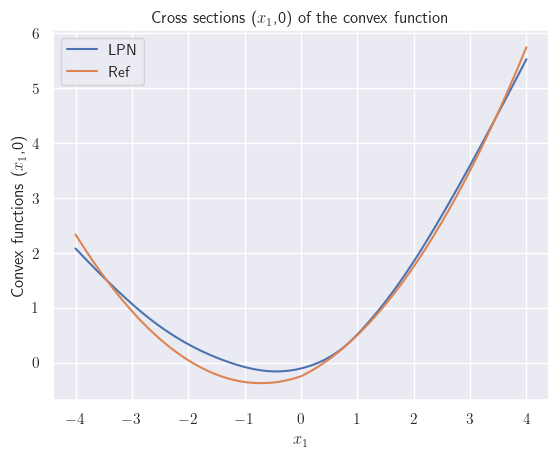

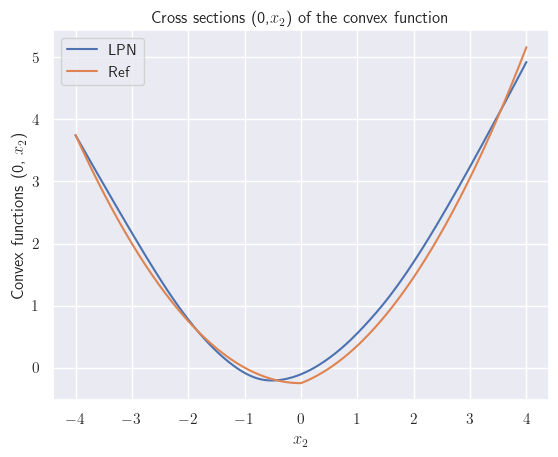

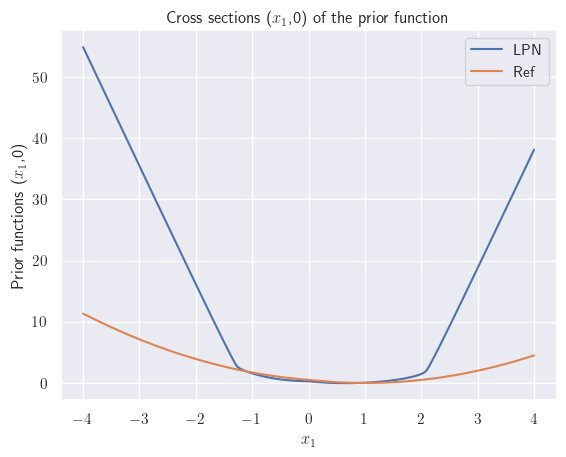

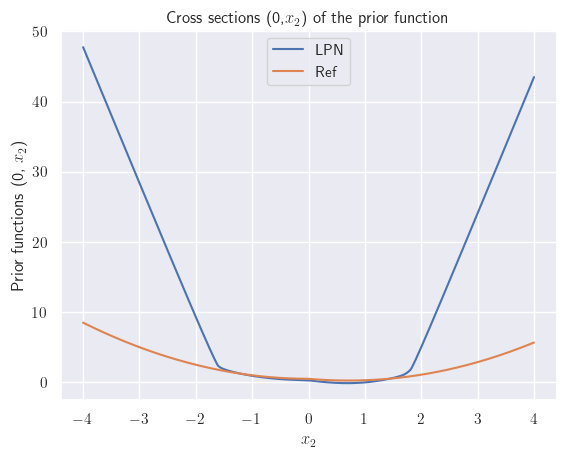

In [18]:
plot_all(lpn_model,a,b,data_points,mu1,mu2,sigma1,sigma2)

gamma = 12.5 -- Train

In [19]:
gamma_loss = 12.5

for g in optimizer.param_groups:
    g["lr"] = 1e-5

for i in range(6000):
    single_iteration(i, data_points, lpn_model, optimizer, loss_type, gamma_loss)

torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, f"l_{gamma_loss}.pth"))

iteration 0 loss 0.0003905266639776528
iteration 500 loss 0.00022611170425079763
iteration 1000 loss 0.00013576388300862163
iteration 1500 loss 8.40875509311445e-05
iteration 2000 loss 5.302667705109343e-05
iteration 2500 loss 3.371566708665341e-05
iteration 3000 loss 2.286374547111336e-05
iteration 3500 loss 1.5742778487037867e-05
iteration 4000 loss 1.0930001735687256e-05
iteration 4500 loss 7.716715117567219e-06
iteration 5000 loss 5.555451025429647e-06
iteration 5500 loss 4.0897725739341695e-06


gamma = 12.5 -- Plot

loss -119.21687316894531
loss -708.4600830078125
loss -1166.0950927734375
loss -1541.41455078125
loss -1860.7659912109375
loss -2146.066162109375
loss -2391.702392578125
loss -2588.87646484375
loss -2751.813720703125
loss -2890.3388671875
loss -3011.109375
loss -3123.51318359375
loss -3232.024658203125
loss -3338.493408203125
loss -3444.41455078125
loss -3550.890625
loss -3658.328125
loss -3766.65185546875
loss -3875.6279296875
loss -3985.035400390625
loss -4094.697998046875
loss -4204.4716796875
loss -4314.2353515625
loss -4423.9013671875
loss -4533.43017578125
loss -4642.818359375
loss -4752.078125
loss -4861.220703125
loss -4970.24267578125
loss -5079.1318359375
loss -5187.89111328125
loss -5296.509765625
loss -5404.9765625
loss -5513.2802734375
loss -5621.4169921875
loss -5729.38427734375
loss -5837.154296875
loss -5944.7197265625
loss -6052.08154296875
loss -6159.25830078125
final mse:  0.21736706793308258
max, min: 18.981155 -19.285719
loss -119.21687316894531
loss -726.143310546

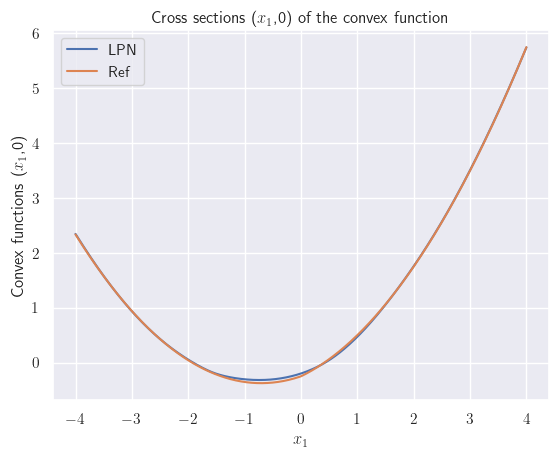

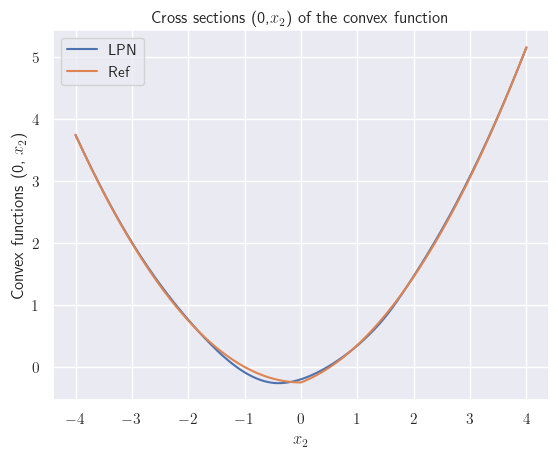

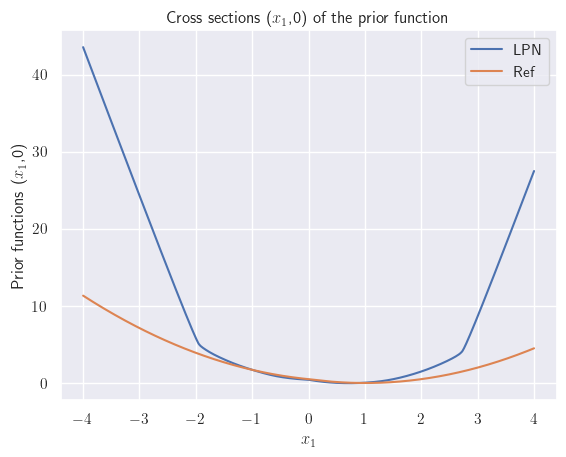

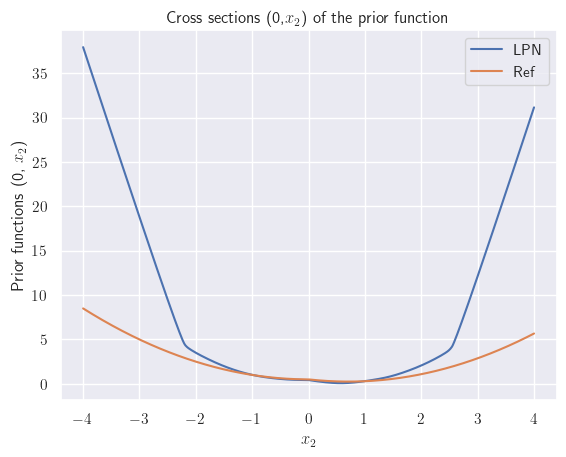

In [20]:
plot_all(lpn_model,a,b,data_points,mu1,mu2,sigma1,sigma2)

gamma = 10 -- Train

In [21]:
gamma_loss = 10

for g in optimizer.param_groups:
    g["lr"] = 1e-5

for i in range(10000):
    single_iteration(i, data_points, lpn_model, optimizer, loss_type, gamma_loss)

torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, f"l_{gamma_loss}.pth"))

iteration 0 loss 4.777908543474041e-06
iteration 500 loss 3.152489625790622e-06
iteration 1000 loss 2.201497636633576e-06
iteration 1500 loss 1.5836953934922349e-06
iteration 2000 loss 1.1539459592313506e-06
iteration 2500 loss 8.460879143967759e-07
iteration 3000 loss 6.219744932423055e-07
iteration 3500 loss 4.5508147650252795e-07
iteration 4000 loss 3.859400692363124e-07
iteration 4500 loss 3.257393927924568e-07
iteration 5000 loss 2.714991467200889e-07
iteration 5500 loss 2.2381544795280206e-07
iteration 6000 loss 2.0533799727218138e-07
iteration 6500 loss 1.9192695788206038e-07
iteration 7000 loss 1.7493962900516635e-07
iteration 7500 loss 1.600384678113187e-07
iteration 8000 loss 1.4543533666255826e-07
iteration 8500 loss 1.2814999195143173e-07
iteration 9000 loss 1.2159347306806012e-07
iteration 9500 loss 1.1533498422977573e-07


gamma = 10 -- Plot

loss -126.79449462890625
loss -700.6156616210938
loss -1161.515380859375
loss -1543.60302734375
loss -1869.420166015625
loss -2153.35302734375
loss -2389.663818359375
loss -2582.192138671875
loss -2745.169677734375
loss -2884.776123046875
loss -2999.28515625
loss -3093.7001953125
loss -3176.847900390625
loss -3254.529052734375
loss -3329.283447265625
loss -3402.5458984375
loss -3475.507568359375
loss -3548.902099609375
loss -3622.938720703125
loss -3697.556640625
loss -3772.60888671875
loss -3847.927001953125
loss -3923.357177734375
loss -3998.779052734375
loss -4074.10693359375
loss -4149.2939453125
loss -4224.330078125
loss -4299.2333984375
loss -4374.03076171875
loss -4448.7548828125
loss -4523.416015625
loss -4598.0341796875
loss -4672.6025390625
loss -4747.1142578125
loss -4821.5595703125
loss -4895.935546875
loss -4970.244140625
loss -5044.4931640625
loss -5118.68994140625
loss -5192.841796875
final mse:  0.12834230065345764
max, min: 18.704199 -19.094471
loss -126.79449462890625

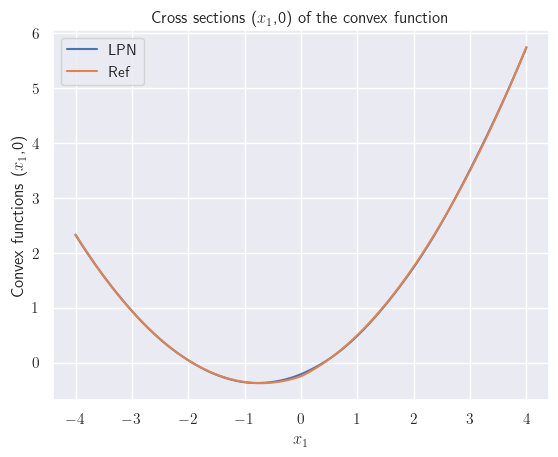

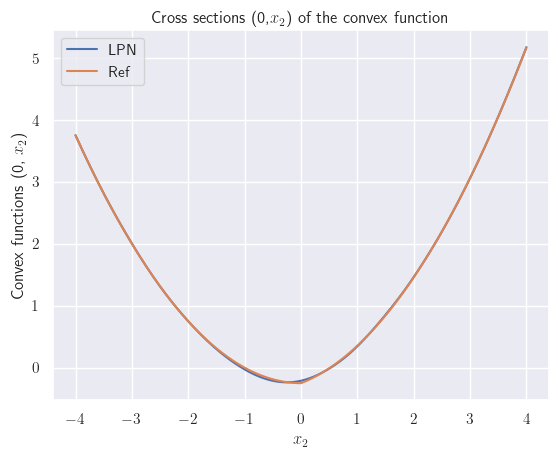

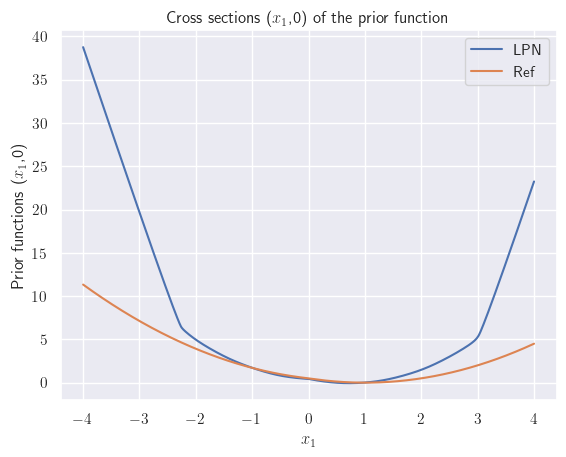

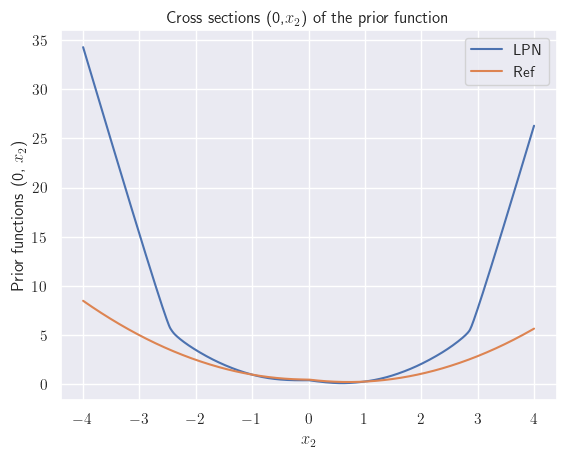

In [22]:
plot_all(lpn_model,a,b,data_points,mu1,mu2,sigma1,sigma2)